# Arterial line study

This notebook reproduces the arterial line study in MIMIC-III. The following is an outline of the notebook:

1. Generate necessary materialized views in SQL
2. Combine materialized views and acquire a single dataframe
3. Write this data to file for use in R

The R code then evaluates whether an arterial line is associated with mortality after propensity matching.

Note that the original arterial line study used a genetic algorithm to select the covariates in the propensity score. We omit the genetic algorithm step, and instead use the final set of covariates described by the authors. For more detail, see:

> Hsu DJ, Feng M, Kothari R, Zhou H, Chen KP, Celi LA. The association between indwelling arterial catheters and mortality in hemodynamically stable patients with respiratory failure: a propensity score analysis. CHEST Journal. 2015 Dec 1;148(6):1470-6.

In [1]:
from __future__ import print_function

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import os

# below is used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline

def execute_query_safely(sql, con):
    cur = con.cursor()
    
    # try to execute the query
    try:
        cur.execute(sql)
    except:
        # if an exception, rollback, rethrow the exception - finally closes the connection
        cur.execute('rollback;')
        raise
    finally:
        cur.close()
    
    return
        

# location of the queries to generate aline specific materialized views
aline_path = './'

# location of the queries to generate materialized views from the MIMIC code repository
concepts_path = '../../concepts/'

# specify user/password/where the database is
sqluser = 'postgres'
sqlpass = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'
host = 'localhost'

In [2]:
# connect to the database
con = psycopg2.connect(dbname=dbname, user=sqluser, password=sqlpass, host=host)

# all queries are prepended by this statement to ensure we use the correct schema
query_schema = 'SET SEARCH_PATH TO public,' + schema_name + ';'
# note that by placing 'public' first, we create materialized views on the public schema
# ... but can still access tables on the `schema_name` table (usually mimiciii)

# 1 - Generate materialized views

Before generating the aline cohort, we require the following materialized views to be already generated:

* angus - from `angus.sql`
* weightdurations - from `weight-durations.sql`
* heightweight - from `heightweight.sql`
* aline_vaso_flag - from `aline_vaso_flag.sql`

You can generate the above by executing the below codeblock. If you haven't changed the directory structure, the below should work, otherwise you may need to modify the `concepts_path` variable above.


**JC: NOTE THAT THIS DOESN'T RUN OUT OF THE BOX - FOLLOW INSTRUCTIONS ON THE CONCEPTS README INSTEAD TO GENERATE ANGUS AND WEIGHT_DURATIONS. FOR ALINE_VASO_FLAG and HEIGHTWEIGHT which are not generated by the previous script, YOU NEED TO DO SOMETHING SIMILAR TO POSTGRES_MAKE_CONCEPTS.SH TO RUN IT.**

**FIRST WE MANUALLY CHANGE mimic-code/concepts/demographics/heightweight.sql. Everywhere that it says < INTERVAL 1 YEAR >, replace it with < INTERVAL '1' YEAR >. One might be able to use the functions in postgres-functions.sql, but I am not so confident in using them**

**JC: I created a script that is similar called postgres_make_aline_concepts.sh. It should be run with bash postgres_make_aline_concepts.sh in the terminal instead of running the box below to make heightweight and aline_vaso_flag.**\

In [10]:
# # list of queries we will execute in turn
# queries = [
#     'sepsis/angus.sql',
#     'durations/weight-durations.sql',
#     'demographics/heightweight.sql',
#     'aline_vaso_flag.sql'
# ]

# for query_file in queries:
#     # load in the text of the query
#     f = os.path.join(concepts_path, query_file)
#     with open(f) as fp:
#         query = ''.join(fp.readlines())
# 
#     # Execute the query
#     print('Generating materialized view using {} ...'.format(f),end=' ')
#     execute_query_safely(query_schema + query, con)
#    print('done.')

Now we generate the *aline_cohort* table using the aline_cohort.sql file.

Afterwards, we can generate the remaining 6 materialized views in any order, as they all depend on only *aline_cohort* and raw MIMIC-III data.

**JC: THERE IS SOME NAMING ISSUE IN THE ALINE_COHORT.SQL FILE. VENTDURATIONS IS ACTUALLY CALLED VENTILATION_DURATIONS. ALINE_COHORT IS MODIFIED HERE TO REFLECT THAT.**

**ADDITIONALLY, SEE THE BOXES ABOVE. WE NEED TO RUN SOMETHING ELSE FOR THE ALINE_VASO_FLAG.**

**ANGUS_SEPSIS IS RENAMED AS ANGUS, SO THAT IS CHANGED AS WELL.**

**LASTLY, WE DON'T CREATE THE VIEW FROM HERE BUT INSTEAD USE THE BASH SCRIPT BELOW. THIS IS SO THAT THE OTHER QUERIES USING ALINE_COHORT CAN JUST FIND IT IN THE DB**

In [12]:
# # Load in the query from file
# f = os.path.join(aline_path,'aline_cohort.sql')
# with open(f) as fp:
#     query = ''.join(fp.readlines())
    
# # Execute the query
# print('Generating materialized view using {} ...'.format(f),end=' ')
# execute_query_safely(query_schema + query, con)
# print('done.')

Generating materialized view using ./aline_cohort.sql ... done.


The following codeblock loads in the SQL from each file in the aline subfolder and executes the query to generate the materialized view. We specifically exclude the aline_cohort.sql file as we have already executed it above. Again, the order of query execution does not matter for these queries. Note also that the filenames are the same as the created materialized view names for convenience.

**AGAIN WE RUN A BASH SCRIPT HERE INSTEAD OF THE BOX BELOW TO GET THE SQL QUERIES TO WORK. IT IS CALLED postgres_make_aline_queries.sh. WE ALSO CHANGE aline_cohort_simple.sql as above to update ventdurations to ventilation_durations and angus_sepsis to angus.**

**WE NEED TO FIRST REPLACE VENTDURATIONS TO VENTILATION_DURATIONS IN THE ALINE_COHORT_SIMPLE.SQL FILE. IN THE SAME FILE, REPLACE LINE 63**

    from icustays ie 

**with**

    from icustays icu

**WE ALSO NEED TO ADD A LINE TO LEFT JOIN ALINE_VASO_FLAG AS VF**

In [11]:
# # get a list of all files in the subfolder
# aline_queries = [f for f in os.listdir(aline_path) 
#                  # only keep the filename if it is actually a file (and not a directory)
#                 if os.path.isfile(os.path.join(aline_path,f))
#                  # and only keep the filename if it is an SQL file
#                 & f.endswith('.sql')
#                 # and we do *not* want aline_cohort - it's generated above
#                 & (f != 'aline_cohort.sql') & (f != 'aline_vaso_flag.sql')]

# for f in aline_queries:
#     print('Executing {} ...'.format(f), end=' ')
#     
#     with open(os.path.join(aline_path,f)) as fp:
#         query = ''.join(fp.readlines())
#         
#     execute_query_safely(query_schema + query, con)
#         
#    print('done.')

Summarize the cohort exclusions before we pull all the data together.

# 2 - Extract all covariates and outcome measures

We now aggregate all the data from the various views into a single dataframe.

In [13]:
# Load in the query from file
query = query_schema + """
--FINAL QUERY
select
  co.subject_id, co.hadm_id, co.icustay_id

  -- static variables from patient tracking tables
  , co.age
  , co.gender
  -- , co.gender_num -- gender, 0=F, 1=M
  , co.intime as icustay_intime
  , co.day_icu_intime -- day of week, text
  --, co.day_icu_intime_num -- day of week, numeric (0=Sun, 6=Sat)
  , co.hour_icu_intime -- hour of ICU admission (24 hour clock)
  , case 
      when co.hour_icu_intime >= 7
       and co.hour_icu_intime < 19
         then 1
      else 0
    end as icu_hour_flag
  , co.outtime as icustay_outtime

  -- outcome variables
  , co.icu_los_day
  , co.hospital_los_day
  , co.hosp_exp_flag -- 1/0 patient died within current hospital stay
  , co.icu_exp_flag -- 1/0 patient died within current ICU stay
  , co.mort_day -- days from ICU admission to mortality, if they died
  , co.day_28_flag -- 1/0 whether the patient died 28 days after *ICU* admission
  , co.mort_day_censored -- days until patient died *or* 150 days (150 days is our censor time)
  , co.censor_flag -- 1/0 did this patient have 150 imputed in mort_day_censored

  -- aline flags
  -- , co.initial_aline_flag -- always 0, we remove patients admitted w/ aline
  , co.aline_flag -- 1/0 did the patient receive an aline
  , co.aline_time_day -- if the patient received aline, fractional days until aline put in

  -- demographics extracted using regex + echos
  , bmi.weight as weight_first
  , bmi.height as height_first
  , bmi.bmi

  -- service patient was admitted to the ICU under
  , co.service_unit

  -- severity of illness just before ventilation
  , so.sofa as sofa_first

  -- vital sign value just preceeding ventilation
  , vi.map as map_first
  , vi.heartrate as hr_first
  , vi.temperature as temp_first
  , vi.spo2 as spo2_first

  -- labs!
  , labs.bun_first
  , labs.creatinine_first
  , labs.chloride_first
  , labs.hgb_first
  , labs.platelet_first
  , labs.potassium_first
  , labs.sodium_first
  , labs.tco2_first
  , labs.wbc_first

  -- comorbidities extracted using ICD-9 codes
  , icd.chf as chf_flag
  , icd.afib as afib_flag
  , icd.renal as renal_flag
  , icd.liver as liver_flag
  , icd.copd as copd_flag
  , icd.cad as cad_flag
  , icd.stroke as stroke_flag
  , icd.malignancy as malignancy_flag
  , icd.respfail as respfail_flag
  , icd.endocarditis as endocarditis_flag
  , icd.ards as ards_flag
  , icd.pneumonia as pneumonia_flag

  -- sedative use
  , sed.sedative_flag
  , sed.midazolam_flag
  , sed.fentanyl_flag
  , sed.propofol_flag
  
from aline_cohort co
-- The following tables are generated by code within this repository
left join aline_sofa so
on co.icustay_id = so.icustay_id
left join aline_bmi bmi
  on co.icustay_id = bmi.icustay_id
left join aline_icd icd
  on co.hadm_id = icd.hadm_id
left join aline_vitals vi
  on co.icustay_id = vi.icustay_id
left join aline_labs labs
  on co.icustay_id = labs.icustay_id
left join aline_sedatives sed
  on co.icustay_id = sed.icustay_id
order by co.icustay_id
"""

# Load the result of the query into a dataframe
df = pd.read_sql_query(query, con)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
subject_id,2522.0,41200.147105,29718.522540,22.000000,15635.000000,31266.000000,66550.500000,99881.000000
hadm_id,2522.0,149894.153053,29257.094716,100016.000000,124240.000000,150226.000000,175301.000000,199962.000000
icustay_id,2522.0,250817.708565,28925.940512,200019.000000,226835.000000,251647.000000,275829.000000,299995.000000
age,2522.0,64.552130,50.094932,16.203184,42.348493,57.127327,73.750108,300.052602
hour_icu_intime,2522.0,12.766852,7.532421,0.000000,5.000000,14.000000,19.000000,23.000000
icu_hour_flag,2522.0,0.404837,0.490958,0.000000,0.000000,0.000000,1.000000,1.000000
icu_los_day,2522.0,3.656302,3.403138,1.000579,1.709094,2.524954,4.337101,37.304780
hospital_los_day,2522.0,8.443722,7.820420,0.038194,3.806424,6.446528,10.523090,123.687500
hosp_exp_flag,2522.0,0.131245,0.337735,0.000000,0.000000,0.000000,0.000000,1.000000
icu_exp_flag,2522.0,0.090801,0.287383,0.000000,0.000000,0.000000,0.000000,1.000000


Now we need to remove obvious outliers, including correcting ages > 200 to 91.4 (i.e. replace anonymized ages with 91.4, the median age of patients older than 89).

/home/jojo/anaconda3/envs/mimic_aline_replication/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


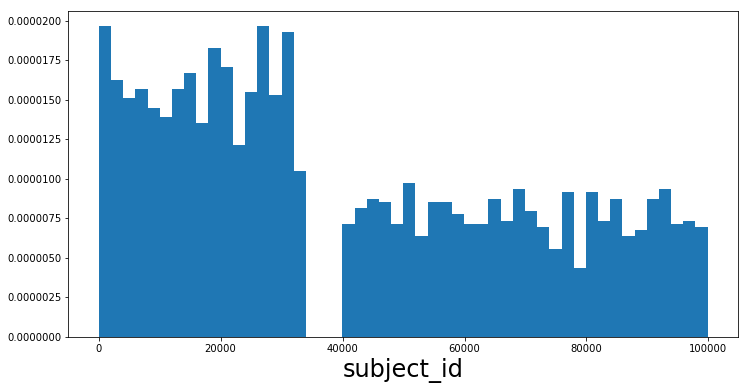

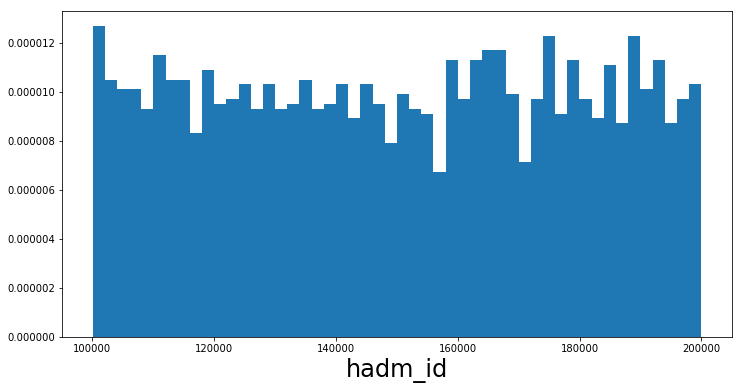

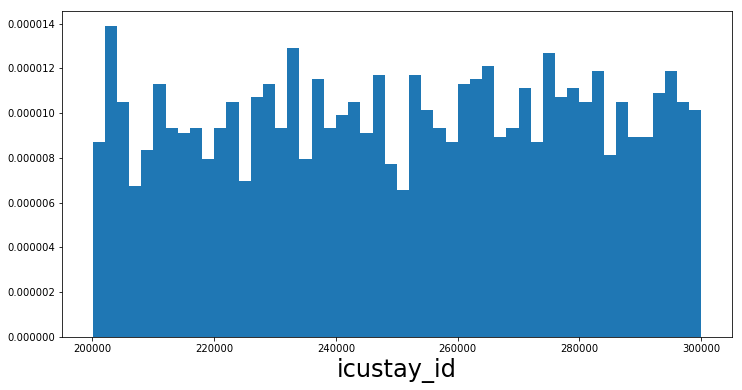

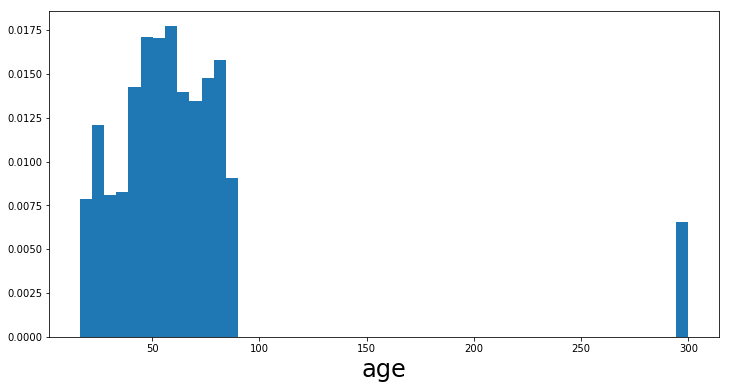

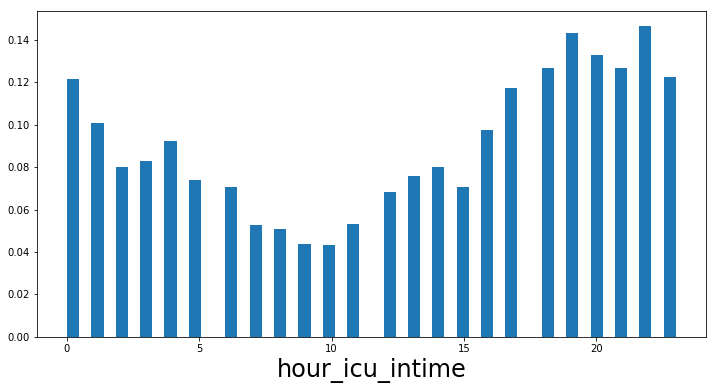

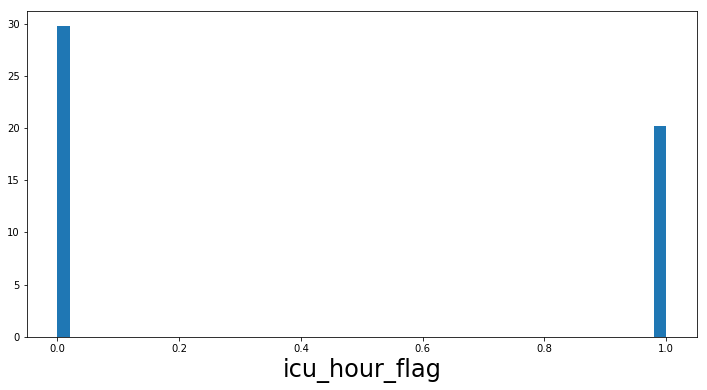

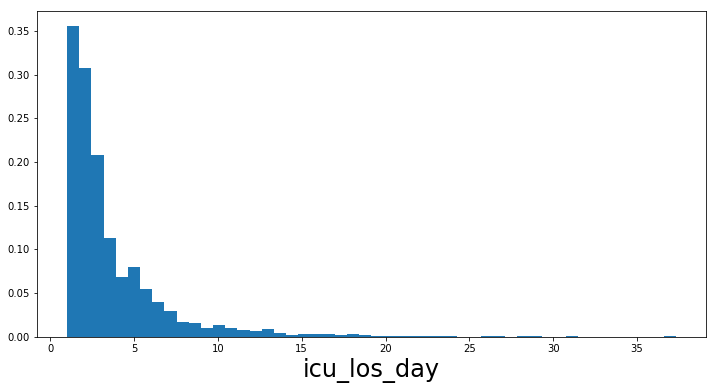

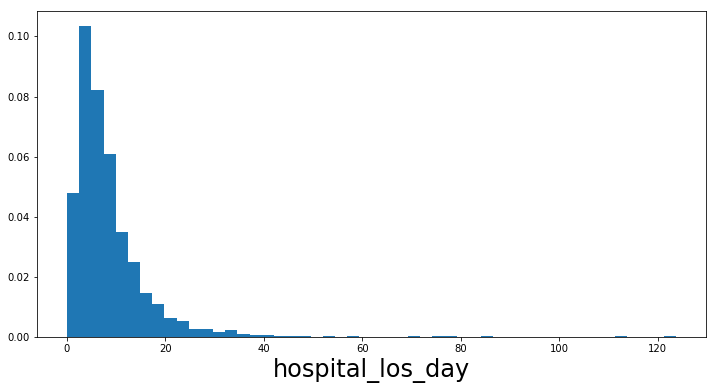

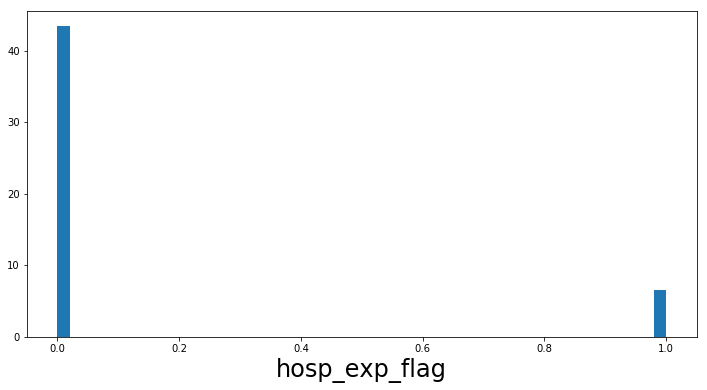

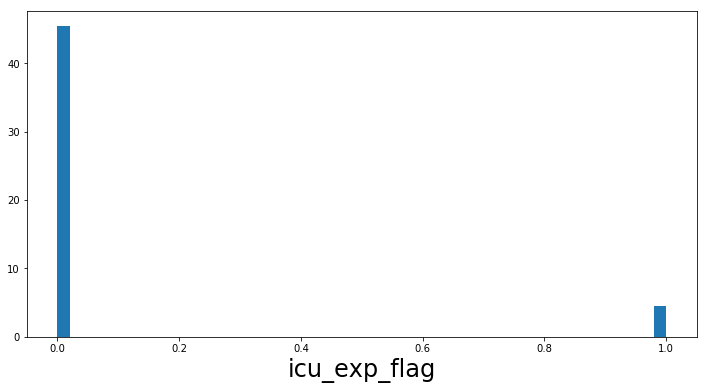

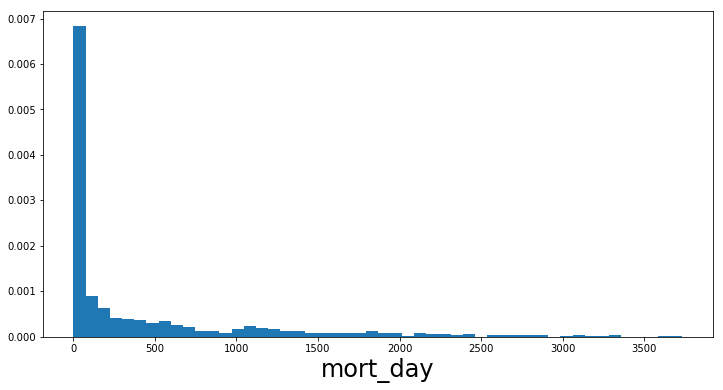

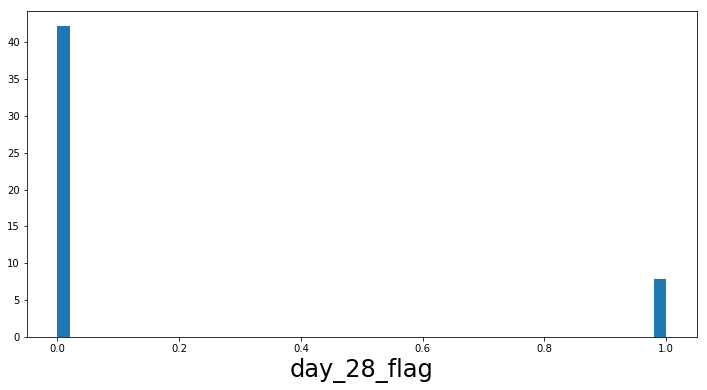

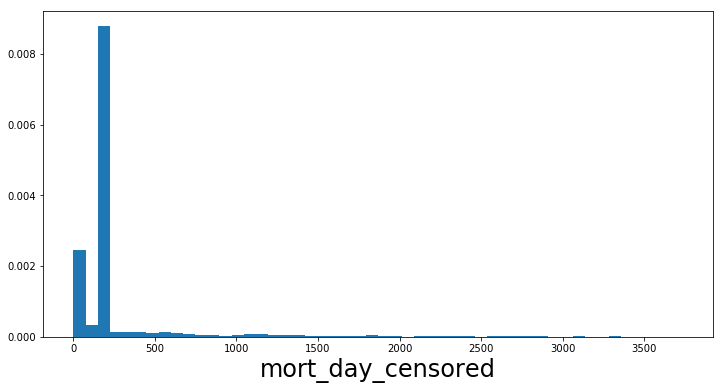

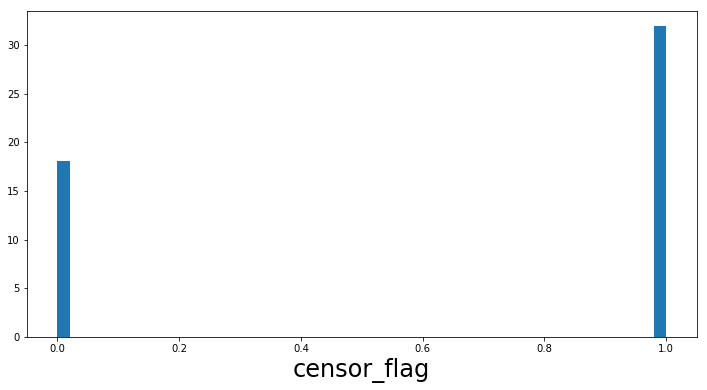

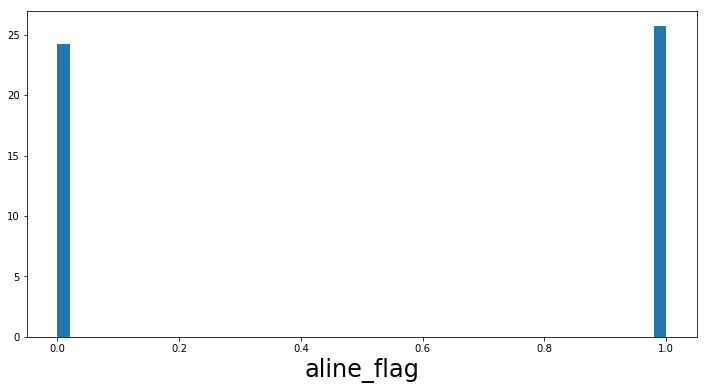

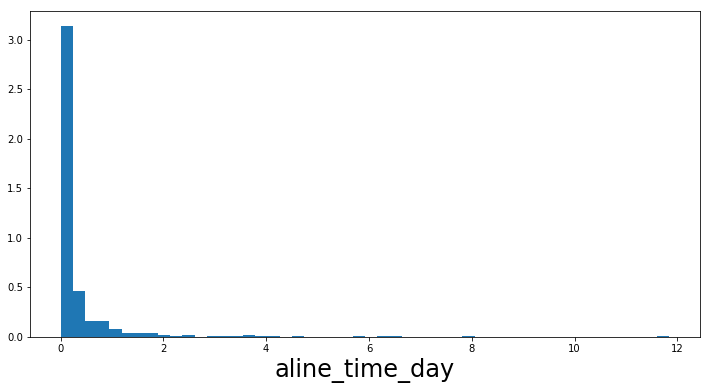

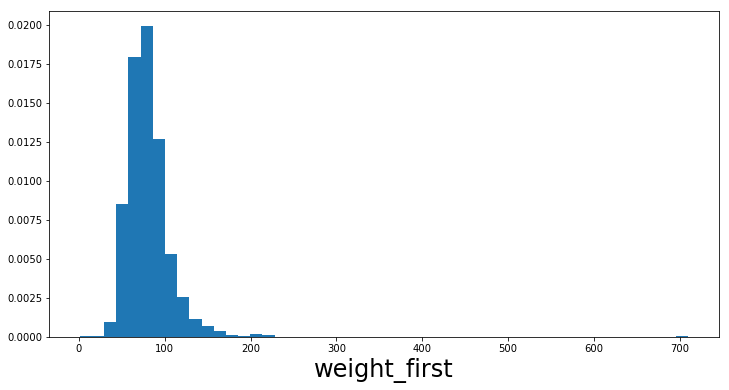

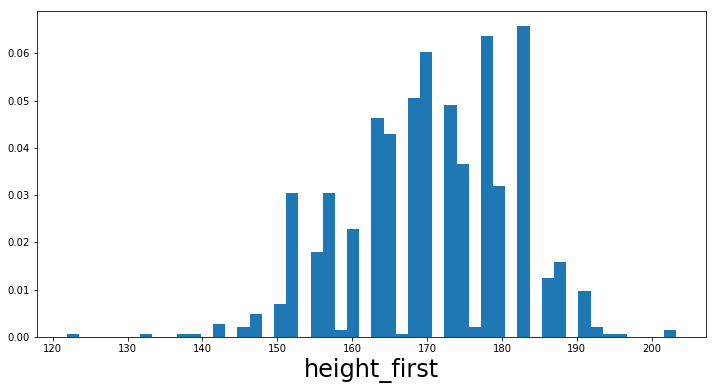

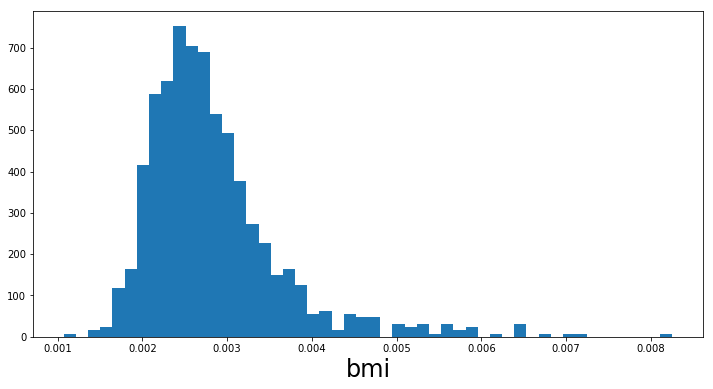

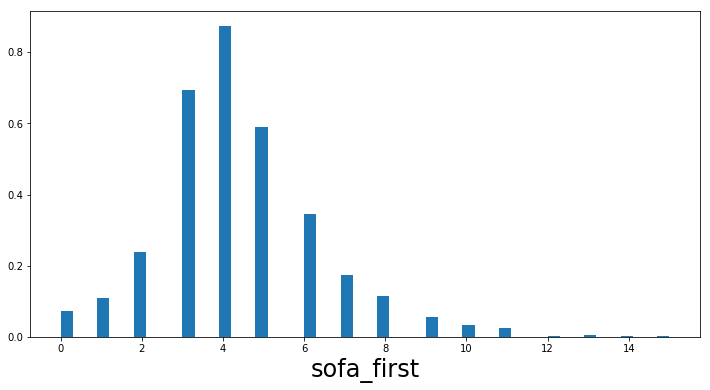

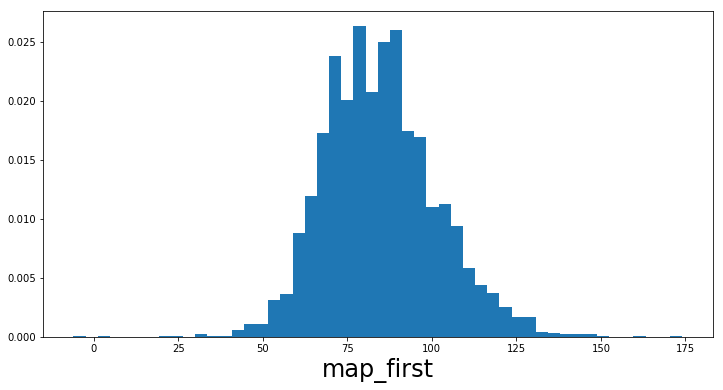

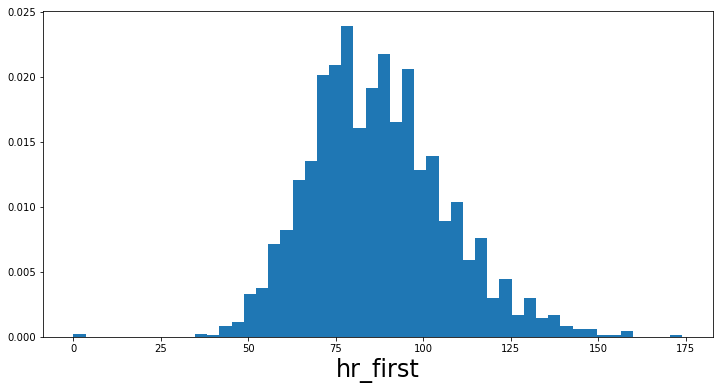

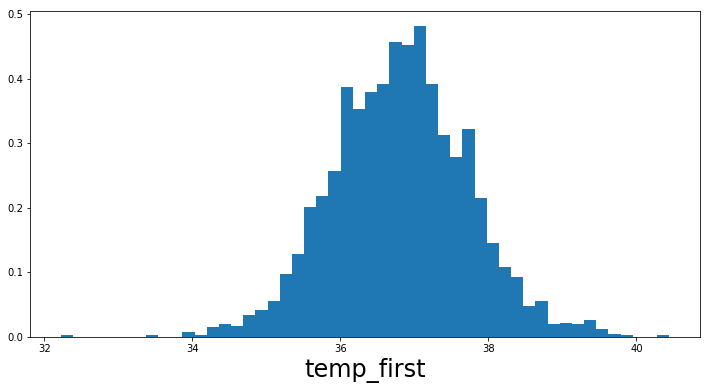

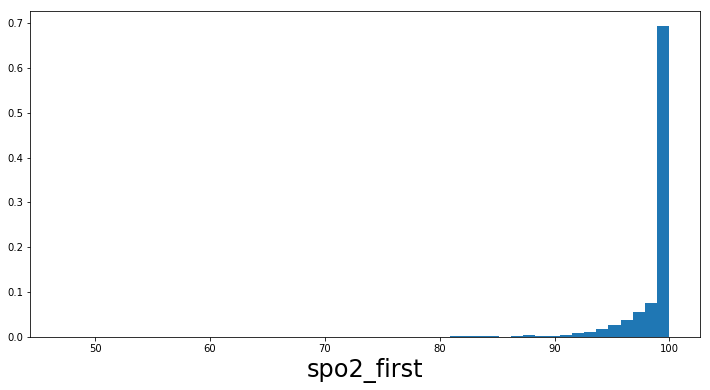

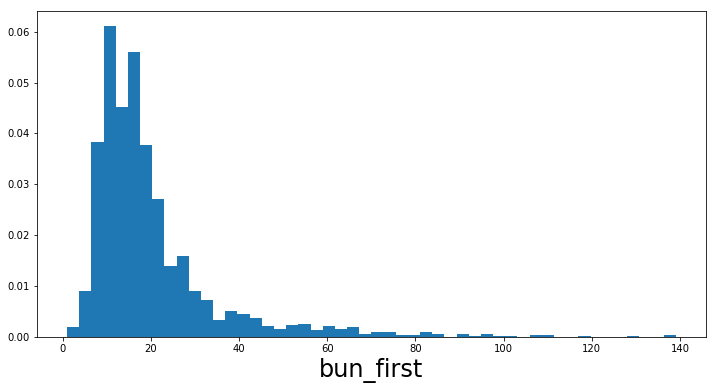

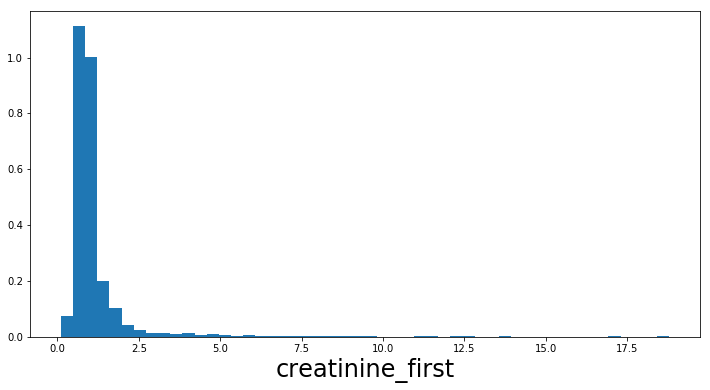

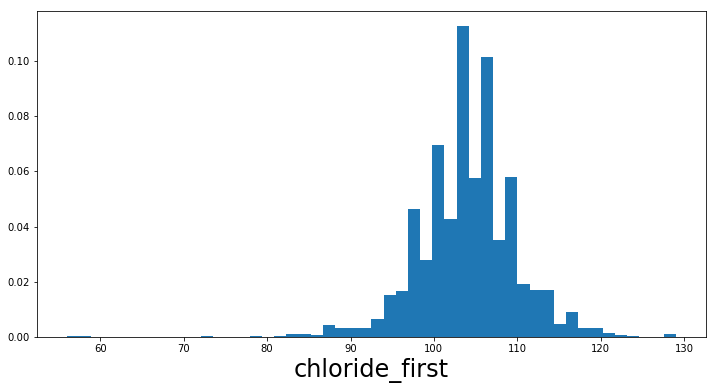

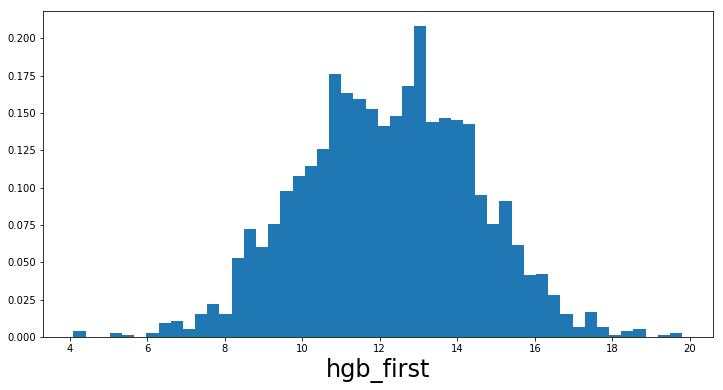

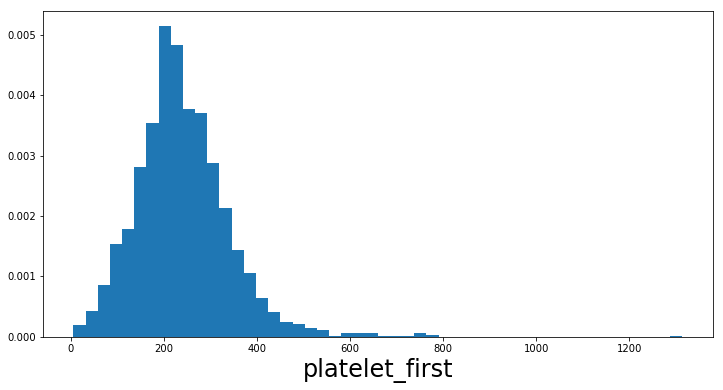

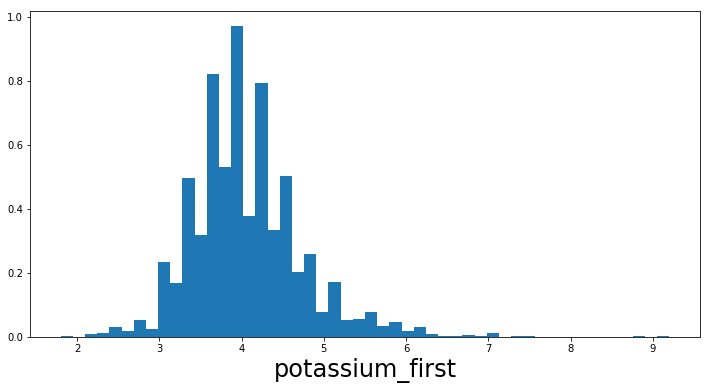

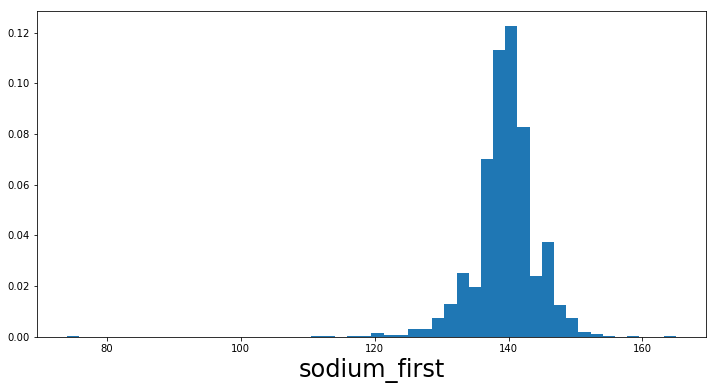

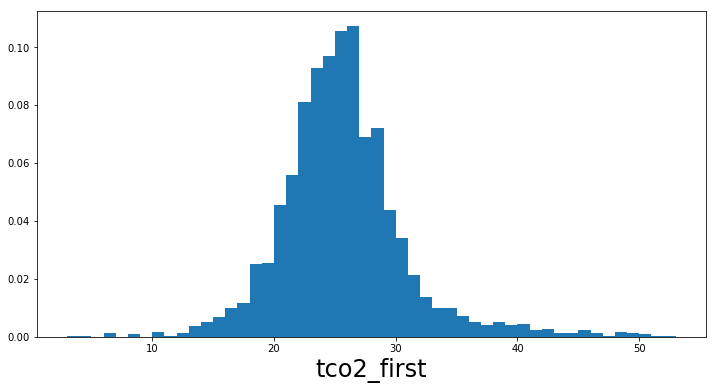

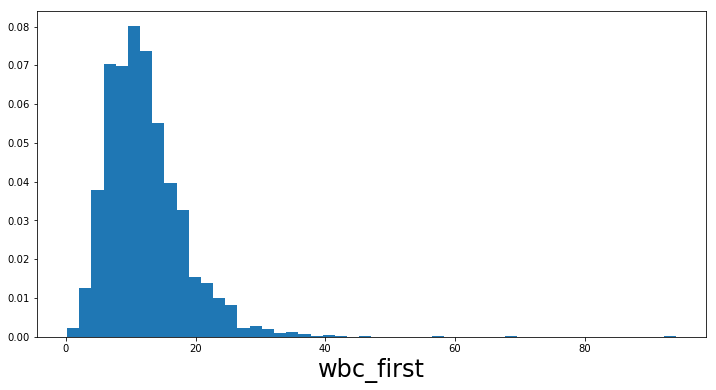

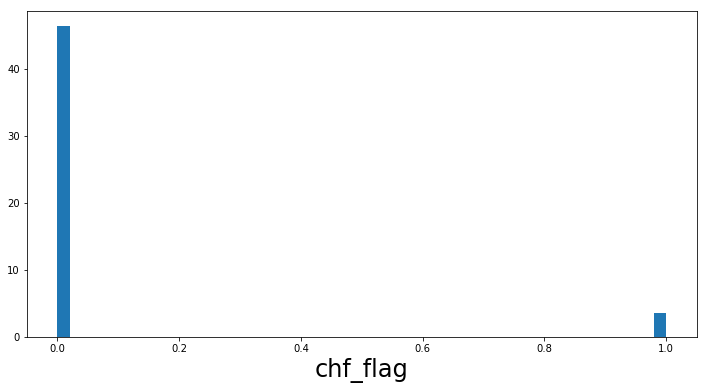

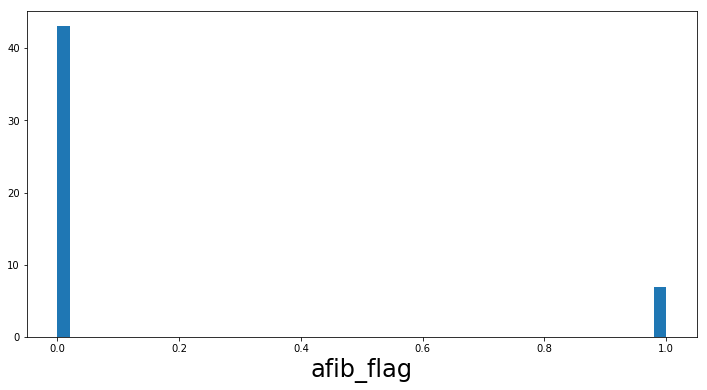

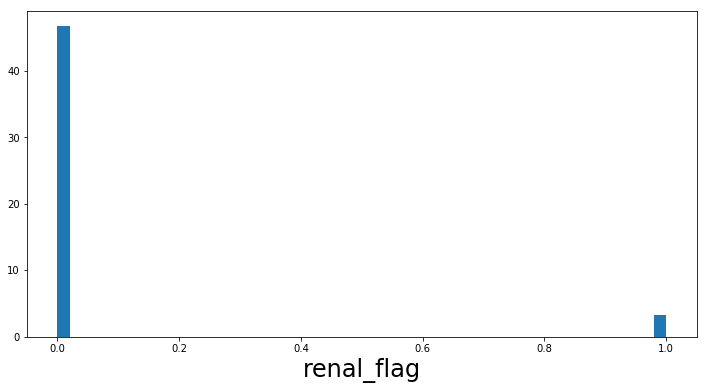

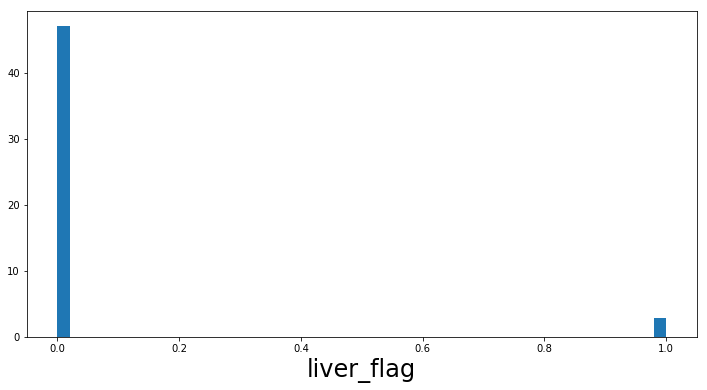

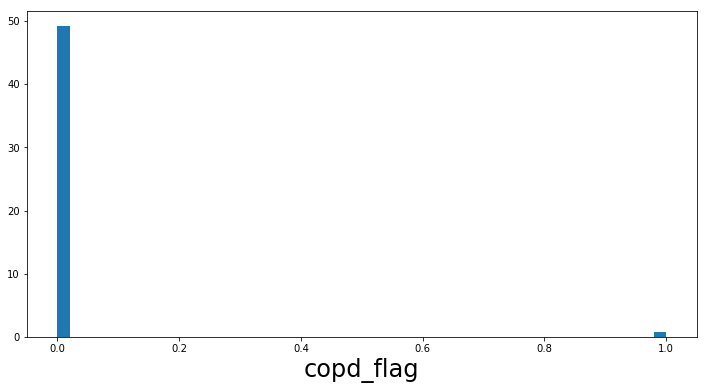

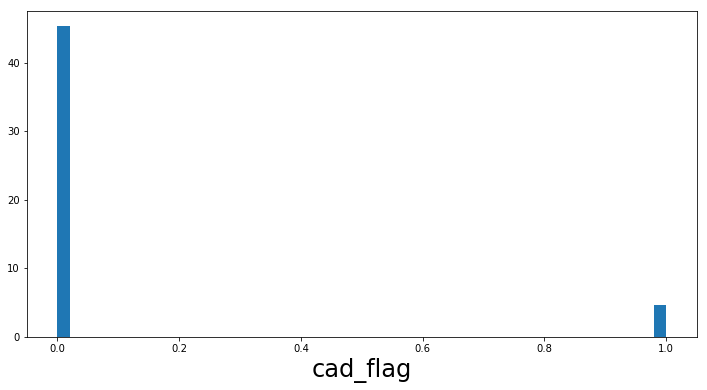

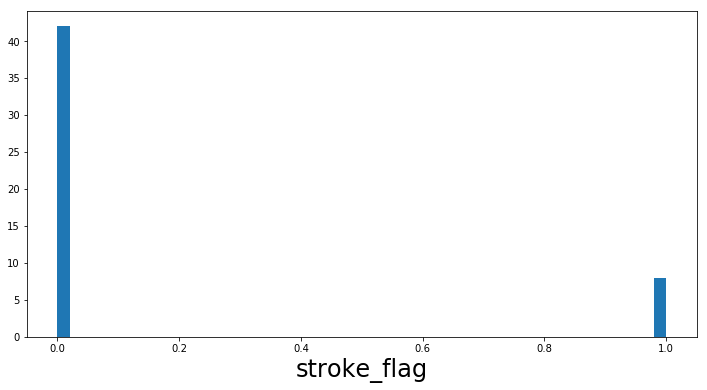

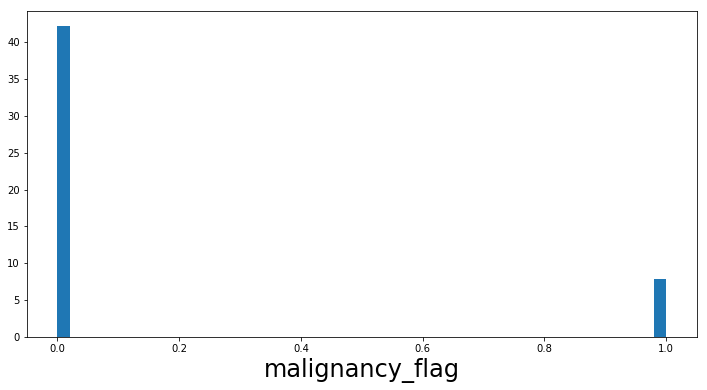

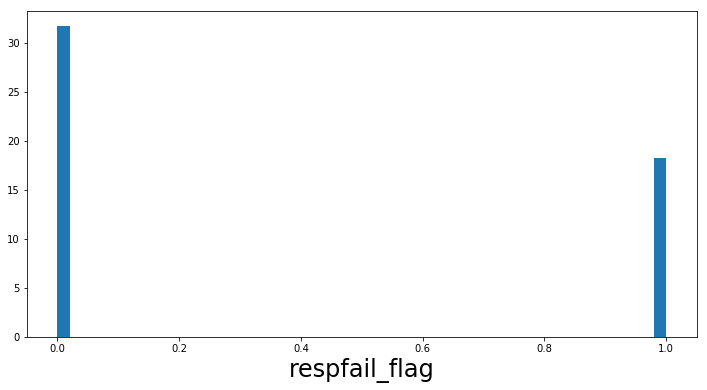

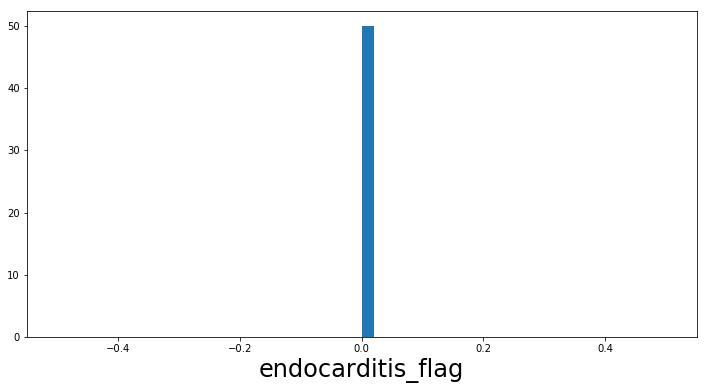

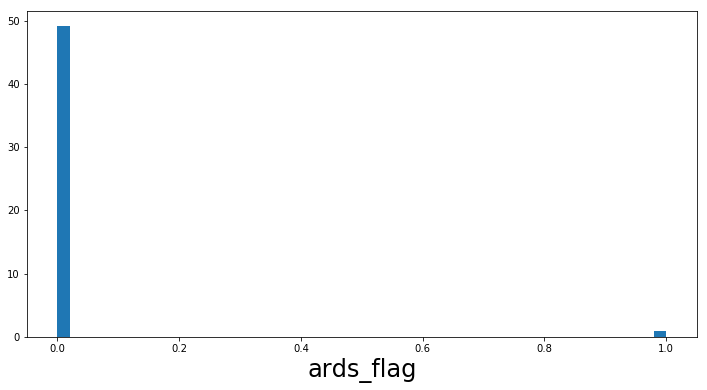

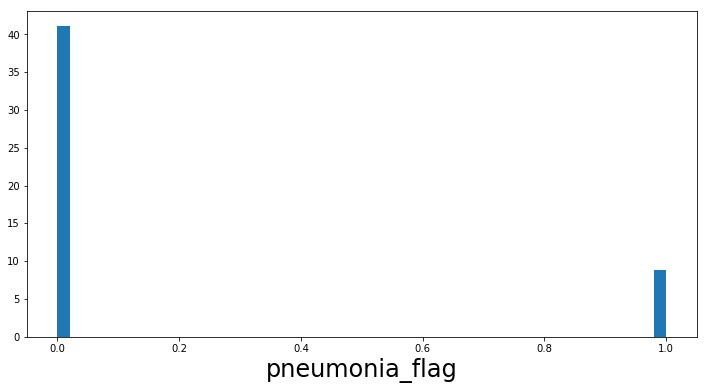

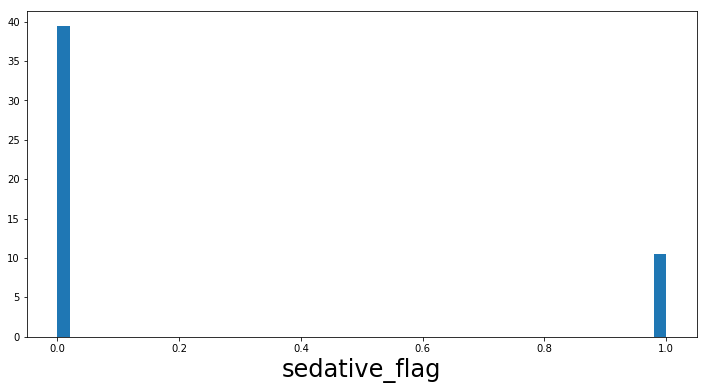

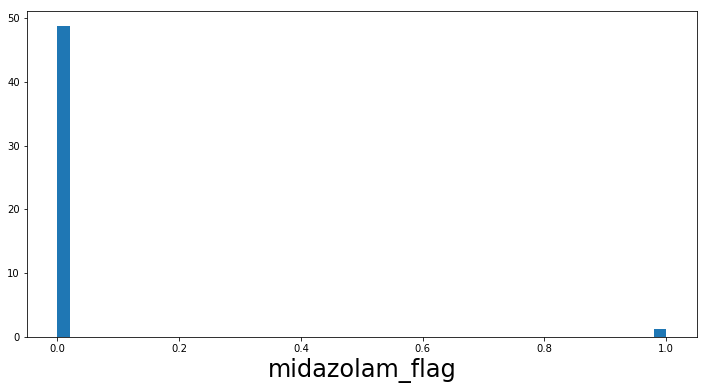

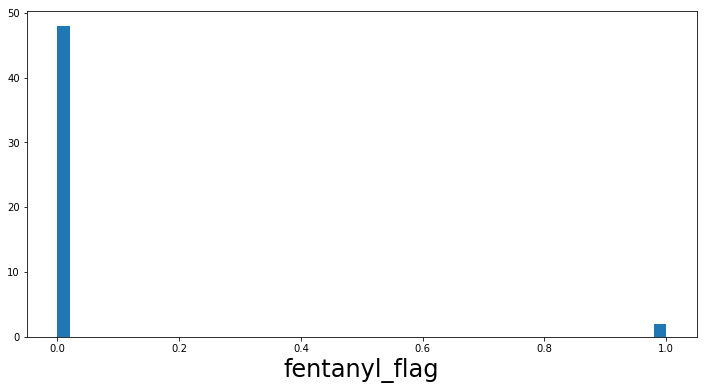

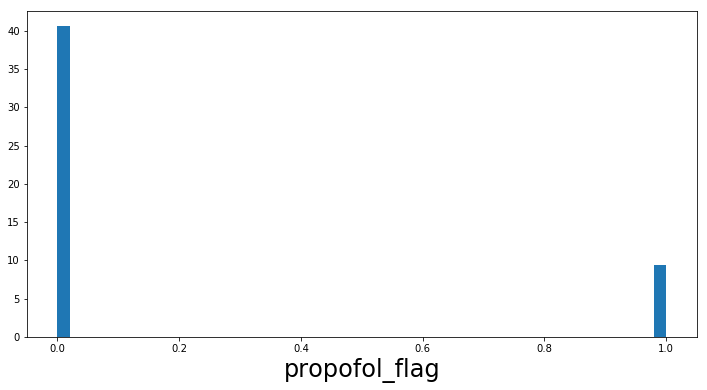

In [14]:
# plot the rest of the distributions
for col in df.columns:
    if df.dtypes[col] in ('int64','float64'):
        plt.figure(figsize=[12,6])
        plt.hist(df[col].dropna(), bins=50, normed=True)
        plt.xlabel(col,fontsize=24)
        plt.show()

In [15]:
# apply corrections
df.loc[df['age']>89, 'age'] = 91.4

# 3 - Write to file

In [16]:
df.to_csv('aline_data.csv',index=False)

# 4 - Create a propensity score using this data

We will create the propensity score using R in the R markdown file `aline_propensity_score.Rmd`.

# 5 - Close the connection to the database

In [17]:
con.close()